In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

In [2]:
#言語モデルなので，次に来る単語を予測する　xt:現在の単語のid, yt:次に来る単語のid
# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100 #idから100列のベクトルに変換する
hidden_size = 100 #RNNレイヤの隠れ層の数
time_size = 5  # Truncated BPTTの展開する時間サイズ 5個ずつ学習する
lr = 0.1
max_epoch = 100

In [3]:
# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:] #正解ラベルは次の単語
print('xs = ', xs) #単語がidで格納されている

data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size)) #418個の単語で構成あされている．Wxhの行数は418

xs =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  27  24  39  26  40  41  42  26  43  32  44  45  46  24  47
  26  27  28  29  48  49  41  42  50  51  52  53  54  55  35  36  37  42
  56  57  58  59  24  35  60  42  61  62  63  64  65  66  67  68  69  70
  35  71  72  42  73  74  75  35  46  42  76  77  64  78  79  80  27  28
  81  82  83  24  32  61  84  26  40  85  26  62  78  86  32  26  87  88
  89  90  64  78  91  92  93  94  95  96  97  82  98  24  26  99  32 100
  42 101 102  26 103  93 104  66 105 106 107  26 108 109  26  67  68 108
  27  24 110 111 112 113  83  79  80  35 114  81  32 115 116 117 108 118
 119 101 120 121  42 122  35 123 124  64 125 101 126  64  32 127  24  35
  26  26  98  56  40 128  29 129  24 130 131 132 133  28  81 134 135 136
  42  61 137 138 139 140  24 141  40 142  61 108 143 144 145  24 146  26
 147  32  82 148 149  32  76 113 150  42 138 

In [4]:
# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr) #確率的勾配降下法

In [5]:
#ミニバッチの作成（時系列順にバッチを作成する必要がある）
#RNNでないなら，バッチはランダムに選ぶ
jump = (corpus_size -1) // batch_size #1000個のデータセットを10分割する
offsets = [i * jump for i in range(batch_size)] 
print(jump)
print(offsets) #バッチを始める位置を格納
#0-98, 99-197 ...を同時に学習する

99
[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]


In [6]:
# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

#学習のコード
for epoch in range(max_epoch):
    for iter in range(max_iters):
        #ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype = 'i') #RNNに時系列を入力するのでtime_size=5個
        batch_t = np.empty((batch_size, time_size), dtype = 'i')
        for t in range(time_size):#1度の学習で長さ５の時系列データを10個ずつ学習する
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] 
                batch_t[i, t] = ts[(offset + time_idx) % data_size] #末尾まで行ったら最初に戻ってくる
            time_idx += 1 #time_idxは初期化されないので学習ごとに違うバッチが読み込まれる
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads) #パラメータをSDGSで更新
        total_loss += loss
        loss_count += 1
    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count) #各エポックでの平均損失でパープレキシティを評価
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0 #エポックごとに計算するので初期化

| epoch 1 | perplexity 397.77
| epoch 2 | perplexity 283.01
| epoch 3 | perplexity 228.74
| epoch 4 | perplexity 216.09
| epoch 5 | perplexity 206.65
| epoch 6 | perplexity 202.42
| epoch 7 | perplexity 199.78
| epoch 8 | perplexity 197.47
| epoch 9 | perplexity 191.33
| epoch 10 | perplexity 192.85
| epoch 11 | perplexity 189.10
| epoch 12 | perplexity 192.25
| epoch 13 | perplexity 190.28
| epoch 14 | perplexity 190.66
| epoch 15 | perplexity 189.88
| epoch 16 | perplexity 186.73
| epoch 17 | perplexity 183.97
| epoch 18 | perplexity 180.94
| epoch 19 | perplexity 181.73
| epoch 20 | perplexity 182.76
| epoch 21 | perplexity 181.17
| epoch 22 | perplexity 176.60
| epoch 23 | perplexity 173.81
| epoch 24 | perplexity 174.75
| epoch 25 | perplexity 172.91
| epoch 26 | perplexity 172.44
| epoch 27 | perplexity 165.91
| epoch 28 | perplexity 164.80
| epoch 29 | perplexity 161.47
| epoch 30 | perplexity 155.83
| epoch 31 | perplexity 156.54
| epoch 32 | perplexity 150.60
| epoch 33 | perp

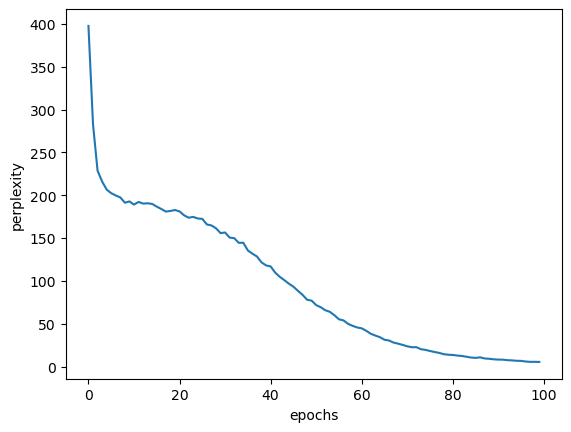

In [7]:
# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()